# Problem 2

In [1]:
## setup

# load libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


# define custom data class
class WineData(Dataset):
    def __init__(self, data):
        # load dataset
        self.data = data
        self.header = self.data.columns.tolist()
        self.preds = torch.Tensor(self.data.drop("quality", axis=1).values)
        self.targets = torch.Tensor(self.data[["quality"]].values)
        
    def __len__(self):
        return len(self.preds)

    def __getitem__(self, rownum):
        preds = self.preds[rownum, :]
        target = self.targets[rownum, :]

        return preds, target
    

# load data
qual_r_raw = pd.read_csv("winequality-red.csv", delimiter=";", dtype="float")
qual_w_raw = pd.read_csv("winequality-white.csv", delimiter=";", dtype="float")

# split into training/test/validation data
qual_r_train, qual_r_other = train_test_split(qual_r_raw, train_size=0.64)
qual_r_val, qual_r_test = train_test_split(qual_r_other, train_size=0.16/(0.16+0.2))
                                           
qual_w_train, qual_w_other = train_test_split(qual_w_raw, train_size=0.64)
qual_w_val, qual_w_test = train_test_split(qual_w_other, train_size=0.16/(0.16+0.2))

# combine into final datasets
qual_train = pd.concat([qual_r_train, qual_w_train], axis=0)
qual_val = pd.concat([qual_r_val, qual_w_val], axis=0)
qual_test = pd.concat([qual_r_test, qual_w_test], axis=0)

In [2]:
# define model architecture

class WiNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.regression = nn.Sequential(
            nn.Linear(11, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.regression(x)
        return x

In [3]:
# set up model plotting
def plot_losses(losses, subplot=False, axis=None, opt="SGD", eta=None, gamma=None):
    if not subplot:
        plt.figure()
        plt.plot(losses[:,1].numpy(), np.log(losses[:,2].numpy()), marker='')
        plt.plot(losses[:,1].numpy(), np.log(losses[:,3].numpy()), marker='')
        # plt.plot(losses[:,1].numpy(), losses[:,2].numpy(), marker='')
        # plt.plot(losses[:,1].numpy(), losses[:,3].numpy(), marker='')
        plt.xlabel("Batch #")
        plt.ylabel("Log-loss (MSE)")
        plt.legend(["Training loss", "Validation loss"])
        plt.title(f"Training loss vs. mini-batch ({opt})")
        plt.show()
    else:
        axis.plot(losses[:,1].numpy(), np.log(losses[:,2].numpy()), marker='', label="Training loss")
        axis.plot(losses[:,1].numpy(), np.log(losses[:,3].numpy()), marker='', label="Validation loss")
        axis.set_xlabel("Batch #")
        axis.set_ylabel("Log-loss (MSE)")
        axis.set_title(f"eta={eta}, gamma={gamma}")
        axis.legend()

# set up model training
def train(model, train, val, epoch, gamma=0, eta=0.0005, N=32, opt="SGD", steplr=False):
    # set up variable storing loss values, by batch/epoch    
    # set up loss function
    losses = []
    criterion = nn.MSELoss()
    
    # set optimizer
    if opt == "SGD":
        optimizer = optim.SGD(model.parameters(),lr=eta, momentum=0, weight_decay=gamma)
    elif opt == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=eta, weight_decay=gamma)
    else:
        opt = "Adam"
        optimizer = optim.Adam(model.parameters(), lr=eta, weight_decay=gamma)
        
    train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=N)
    
    # loop through batches
    i = 0
    for batch_id, (train_data, train_target) in enumerate(train_loader):
        optimizer.zero_grad()
        train_output = model(train_data)
        val_output = model(val.preds)
        
        loss = criterion(train_output, train_target)
        val_loss = criterion(val_output, val.targets)
        
        loss.backward()
    
        optimizer.step()
        if steplr:
            StepLR(optimizer, step_size=30, gamma=gamma).step()
        
        if batch_id == 0:
            losses = torch.Tensor([[1, batch_id, loss, val_loss]])
        else:
            losses = torch.cat((losses, torch.Tensor([[1, batch_id, loss, val_loss]])), dim=0)

        i += 1
    
    return losses, model

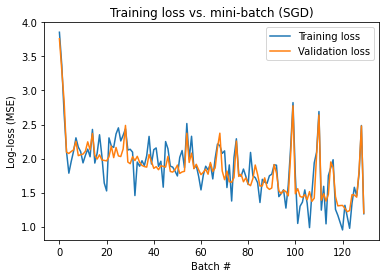

In [4]:
train_dataset = WineData(qual_train)
val_dataset = WineData(qual_val)
model =  WiNet()
epoch = 1
losses, model_trained = train(model, train_dataset, val_dataset, 1)
plot_losses(losses)

It makes sense in this case to treat wine quality as a continuous variable because it preserves the order of the ratings, so features that are associated with turning a low-quality wine into a mid-quality wine are also associated with turning a mid-quality wine into a high-quality wine. This prevents a situation we could run into with a muticlass classifier, where a wine might be considered equally to be either very good or very bad (which is unlikely to happen with a human rater). 

# Problem 3

In [5]:
# setup
from torch.optim.lr_scheduler import StepLR

gammas = [0.1, 0.001, 0.0001]
etas = [10**-2, 10**-3, 10**-4]
Ns = [16, 160, 1600]
losses_rmsprop = []
losses_adam = []

## RMSProp

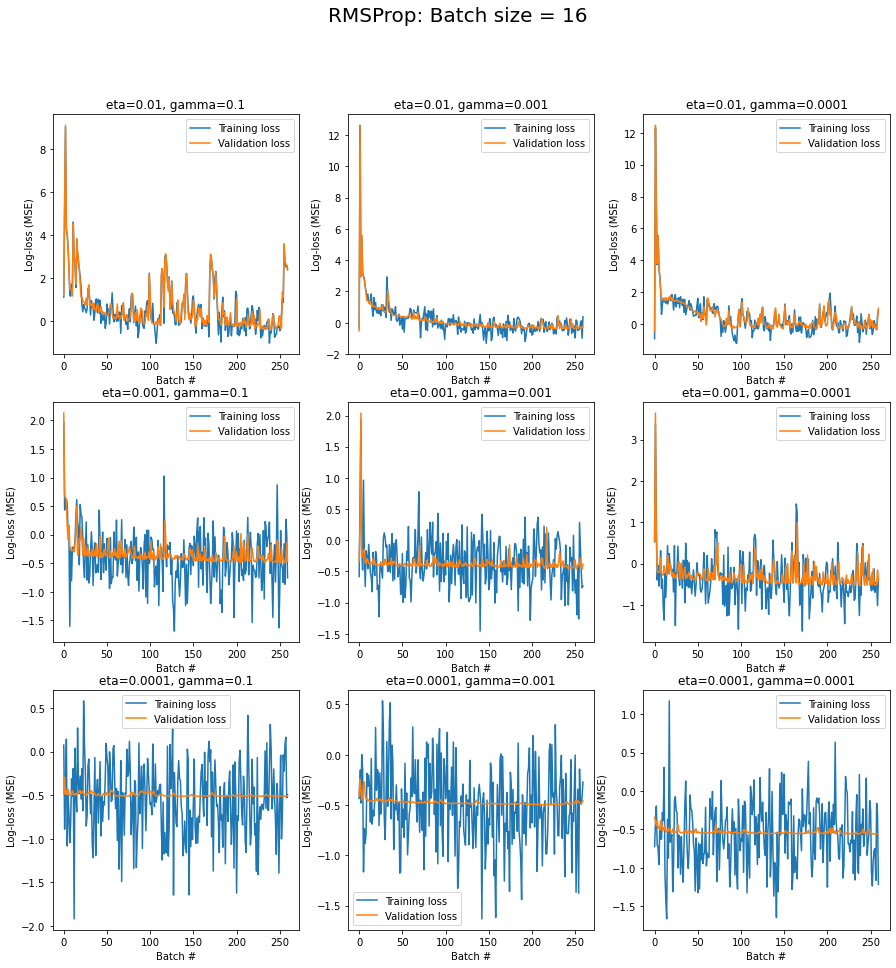

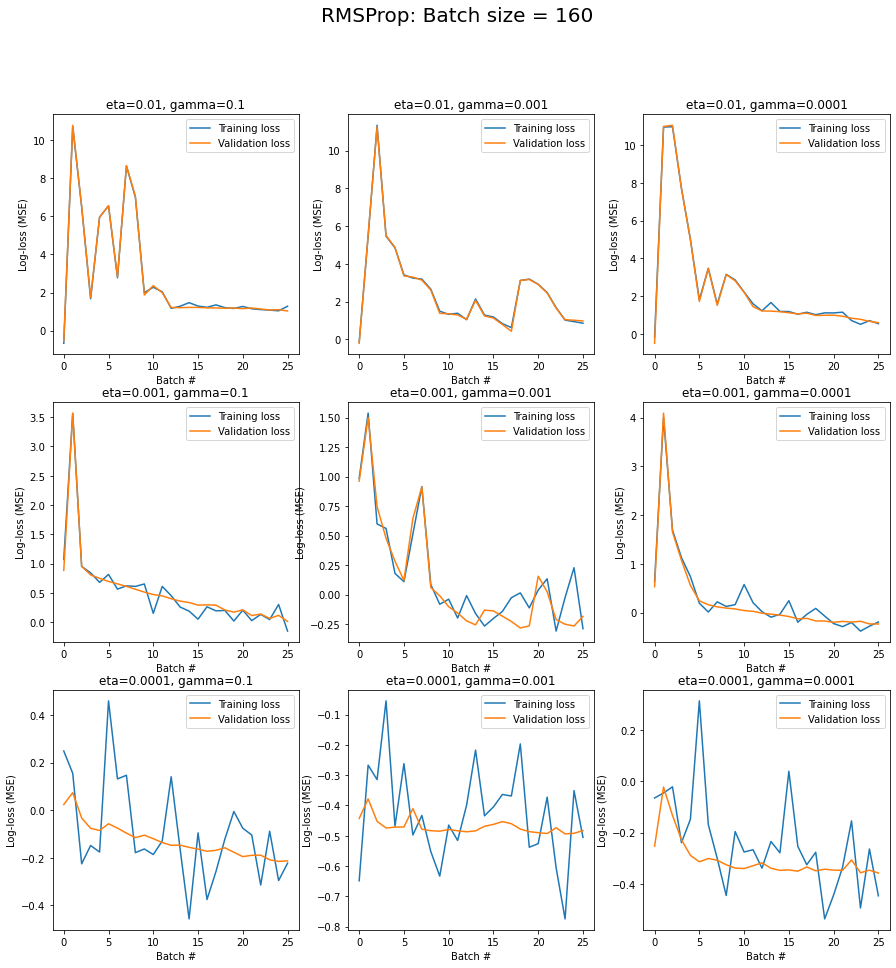

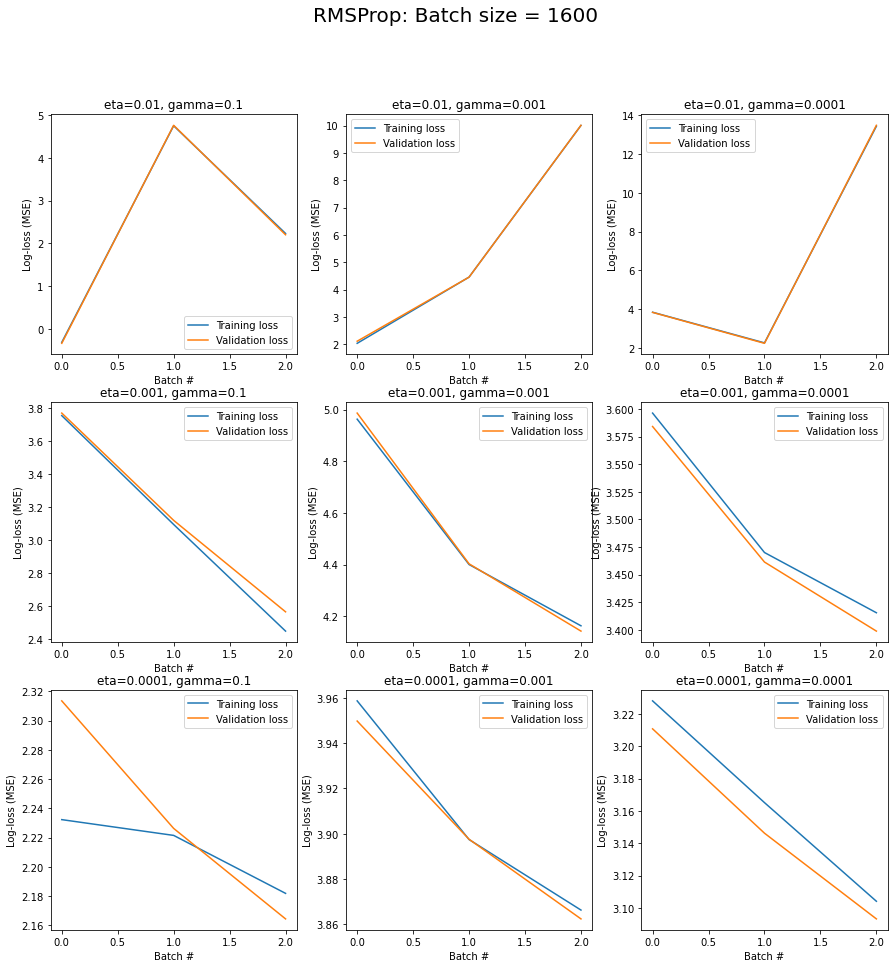

In [6]:
for N in Ns:
    fig, axes = plt.subplots(3, 3, figsize=(15,15))
    y=0
    for gamma in gammas:
        x=0
        for eta in etas:
            # RMSProp
            losses, model_out, = train(model, train_dataset, val_dataset, 1, opt="RMSProp", gamma=gamma, eta=eta, N=N)
            losses_rmsprop.append(losses)
            plot_losses(losses, subplot=True, axis=axes[x,y], opt="RMSProp", eta=eta, gamma=gamma)

            x = x + 1
        y = y + 1
    fig.suptitle(f"RMSProp: Batch size = {N}", fontsize=20)
    plt.show()

## Adam

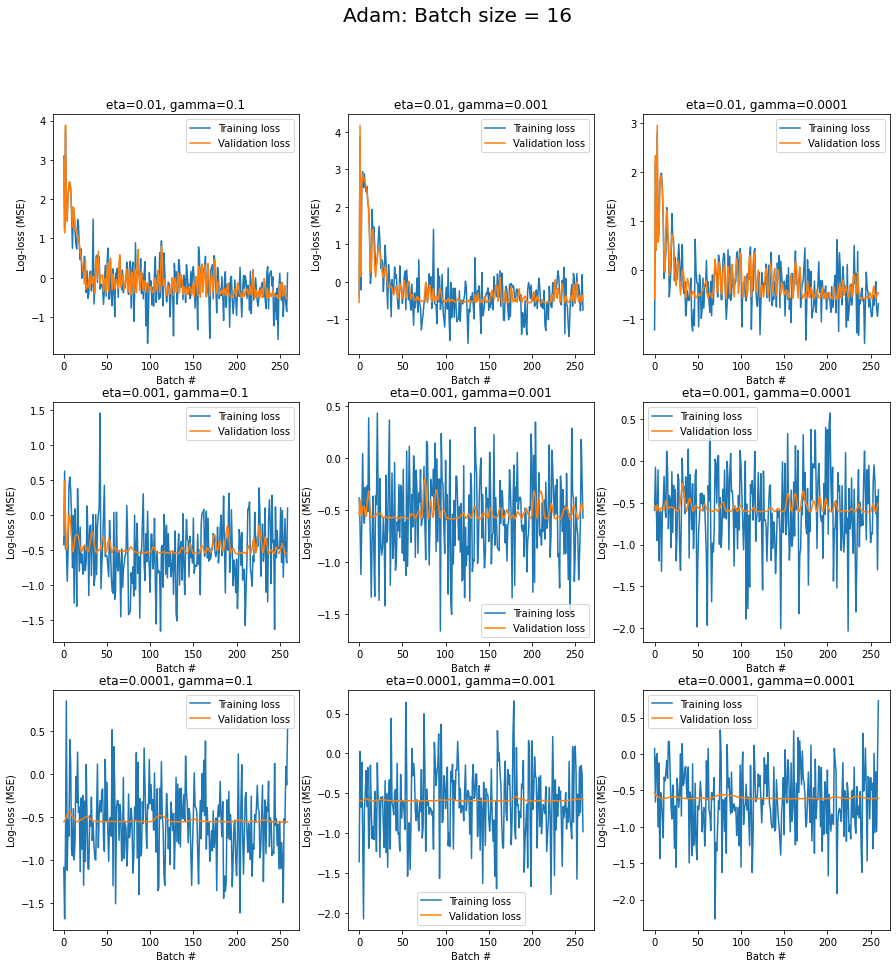

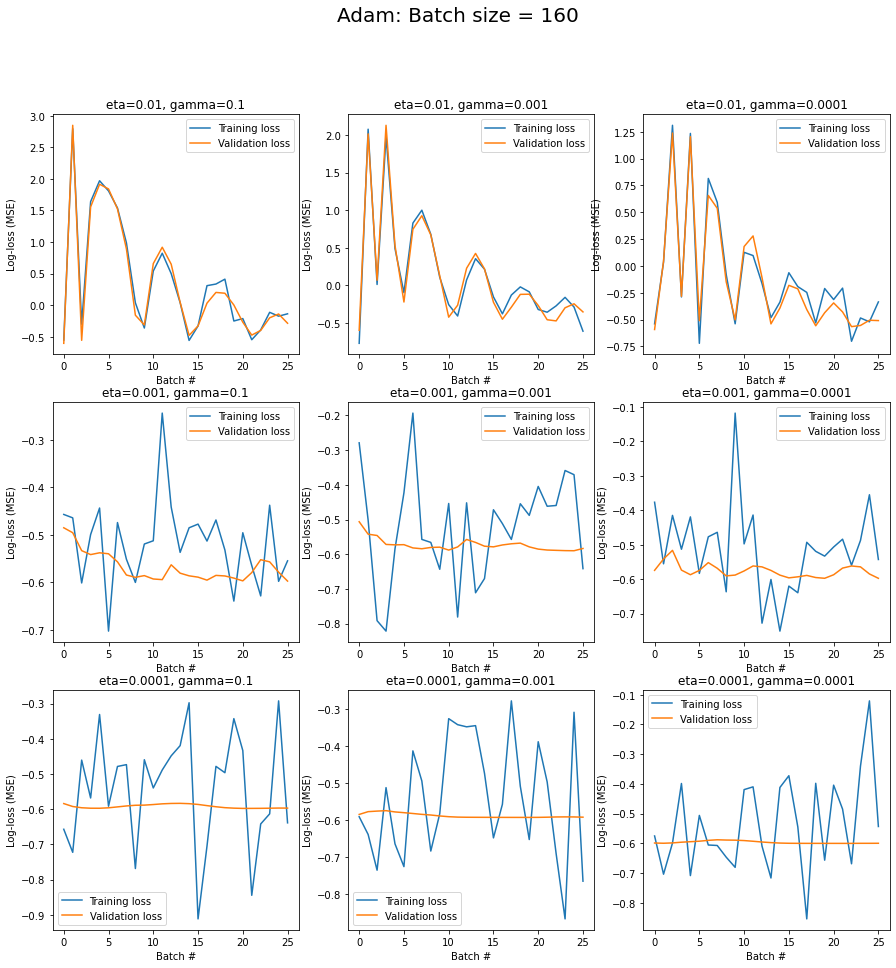

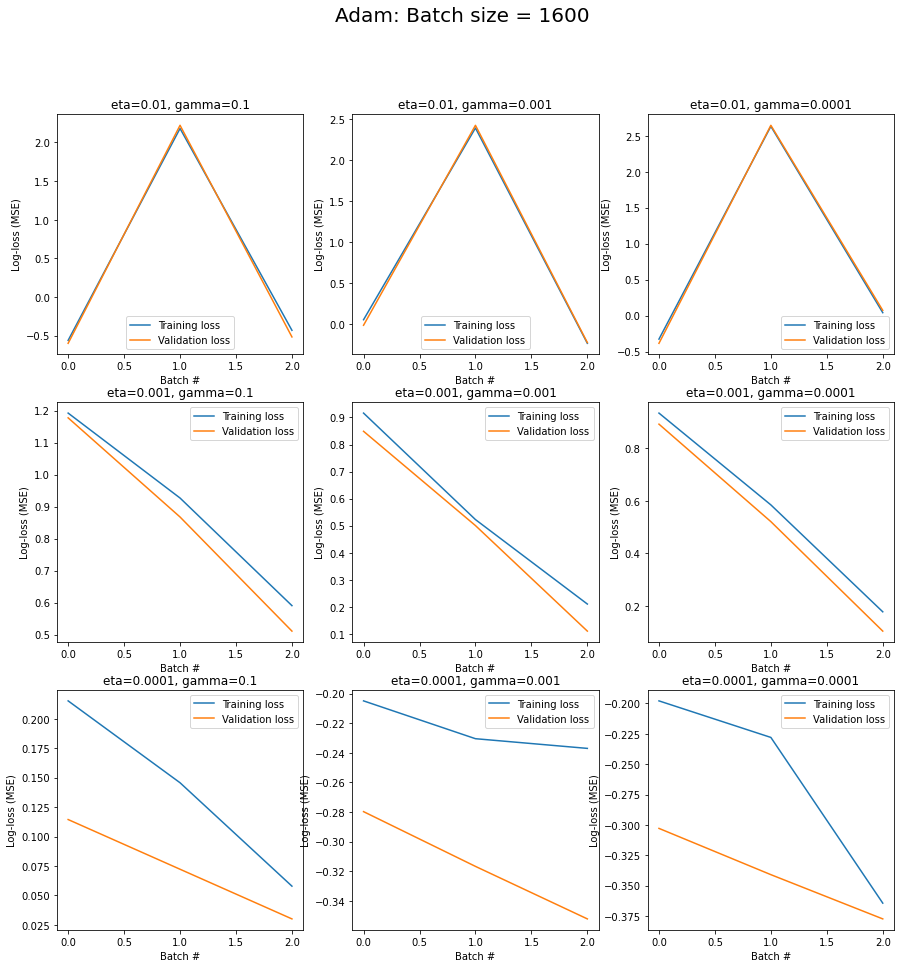

In [7]:
for N in Ns:
    fig2, axes2 = plt.subplots(3, 3, figsize=(15,15))
    y=0
    for gamma in gammas:
        x=0
        for eta in etas:
            # Adam
            losses, _ = train(model, train_dataset, val_dataset, 1, opt="Adam", gamma=gamma, eta=eta, N=N)
            losses_adam.append(losses)
            plot_losses(losses, subplot=True, axis=axes2[x,y], opt="RMSProp", eta=eta, gamma=gamma)

            x = x + 1
        y = y + 1
    fig2.suptitle(f"Adam: Batch size = {N}", fontsize=20)
    plt.show()

 Based on these plots, I would use a batch size of 16 with eta=0.0001 and gamma=0.1, because the model converges more quickly than for smaller values of eta, and because it converges to a lower validation error than higher values of gamma. This is the case for both Adam and RMSProp. Because the training and validation loss are similar for both optimizers given this combination of parameters, the model seems neither overfit nor underfit. 
 
From these results, it's hard to evaluate Goyal's linear scaling rule. From the Adam results, there's some evidence that the helps the model converge faster, but I'm not convinced I see the same pattern in the RMSProp results. 

# Problem 4

In [12]:
# setup
import math
num_loops = 100
lmda = 0.01 # for regularization!

## load MNIST data
train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])
train_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader['mnist'] = torch.utils.data.DataLoader(train_set['mnist'], batch_size=len(train_set['mnist']), shuffle=True, num_workers=0)
test_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader['mnist'] = torch.utils.data.DataLoader(test_set['mnist'], batch_size=len(test_set['mnist']), shuffle=False, num_workers=0)

In [13]:
## separate into training/test datasets
## reshape into Nx784 datasets
batch, y_train = next(iter(train_loader['mnist']))
mnist_train = batch.view(batch.size(0), 784)
batch, y_test = next(iter(test_loader['mnist']))
mnist_test = batch.view(batch.size(0), 784)

## Momentum Method

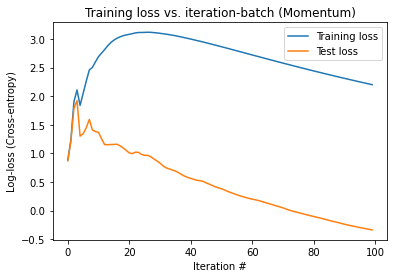

In [14]:
# build logistic regression model
alpha = 1
beta = 0.9

losses = torch.Tensor([])
model = nn.Linear(in_features=784, out_features=10, bias=True)
criterion = nn.CrossEntropyLoss()

# run optimization loop
v = torch.zeros(10, 784).requires_grad_(True)
for i in range(num_loops):
    # calculate loss
    y_hat = model(mnist_train)
    loss = criterion(y_hat, y_train) + lmda*sum(sum(model.weight.data*model.weight.data))
    model.zero_grad()
    loss.backward()    

    # update weights
    w = [i for i in model.parameters()][0]
    v = beta*v + w.grad
    w = w - alpha*v

    # update losses
    test_loss = criterion(model(mnist_test), y_test)
    losses = torch.cat((losses, torch.Tensor([[1, i, loss, test_loss]])), dim=0)
    
    # move weights back into model
    model.weight.data = w

# plot training/test loss
plt.figure()
plt.plot(losses[:,1].numpy(), np.log(losses[:,2].numpy()), marker='')
plt.plot(losses[:,1].numpy(), np.log(losses[:,3].numpy()), marker='')
plt.xlabel("Iteration #")
plt.ylabel("Log-loss (Cross-entropy)")
plt.legend(["Training loss", "Test loss"])
plt.title(f"Training loss vs. iteration-batch (Momentum)")
plt.show()

# Nesterov's Accelerated Gradient

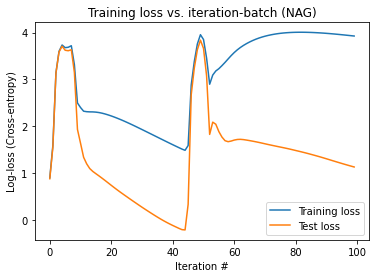

In [15]:
# build logistic regression model
beta = 0.95

losses = torch.Tensor([])
model = nn.Linear(in_features=784, out_features=10, bias=True)
criterion = nn.CrossEntropyLoss()

# run optimization loop

#all_params = torch.cat([param.view(-1) for param in model.parameters() if param.requires_grad])
#print(all_params)
lmda_k = 1 # skipping straight to lmda_1
t = [i for i in model.parameters()][0]
w = [i for i in model.parameters()][0]
for i in range(num_loops):
    # forward pass
    # calculate gradient
    y_hat = model(mnist_train)
    loss = criterion(y_hat, y_train) + lmda*sum(sum(model.weight.data*model.weight.data))
    model.zero_grad()
    loss.backward()
    
    # set up update
    w = [i for i in model.parameters()][0]    
    lmda_k_old = lmda_k
    t_old = t
    
    lmda_k = (1 + math.sqrt(1 + 4*lmda_k_old**2))/2
    gamma_k = (1 - lmda_k_old)/lmda_k
    
    # update weights
    t = w - 1/beta*w.grad
    w = (1 - gamma_k)*t + gamma_k*t_old
    
    # update losses
    test_loss = criterion(model(mnist_test), y_test)
    losses = torch.cat((losses, torch.Tensor([[1, i, loss, test_loss]])), dim=0)
    
    # move weights back into model
    model.weight.data = w

# plot training/test loss
plt.figure()
plt.plot(losses[:,1].numpy(), np.log(losses[:,2].numpy()), marker='')
plt.plot(losses[:,1].numpy(), np.log(losses[:,3].numpy()), marker='')
plt.xlabel("Iteration #")
plt.ylabel("Log-loss (Cross-entropy)")
plt.legend(["Training loss", "Test loss"])
plt.title(f"Training loss vs. iteration-batch (NAG)")
plt.show()

# RMSProp

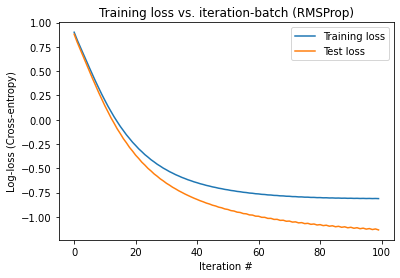

In [16]:
# build logistic regression model
alpha = 10**-3
beta = 0.95
gamma = 1
epsilon = 10**-8

losses = torch.Tensor([])
model = nn.Linear(in_features=784, out_features=10, bias=True)
criterion = nn.CrossEntropyLoss()

# run optimization loop

v = torch.zeros(10, 784)
for i in range(num_loops):
    # forward pass
    # calculate gradient
    y_hat = model(mnist_train)
    loss = criterion(y_hat, y_train) + lmda*sum(sum(model.weight.data*model.weight.data))
    model.zero_grad()
    loss.backward()
    
    # set up update
    w = [i for i in model.parameters()][0]
    v = (1-beta)*v + beta*(w.grad * w.grad)
    b = gamma*torch.ones(10, 784) / (epsilon + torch.sqrt(v))
    
    # update weights
    w = w - alpha * b * w.grad
    
    # update losses
    test_loss = criterion(model(mnist_test), y_test)
    losses = torch.cat((losses, torch.Tensor([[1, i, loss, test_loss]])), dim=0)
    
    # move weights back into model
    model.weight.data = w
    
# plot training/test loss
plt.figure()
plt.plot(losses[:,1].numpy(), np.log(losses[:,2].numpy()), marker='')
plt.plot(losses[:,1].numpy(), np.log(losses[:,3].numpy()), marker='')
plt.xlabel("Iteration #")
plt.ylabel("Log-loss (Cross-entropy)")
plt.legend(["Training loss", "Test loss"])
plt.title(f"Training loss vs. iteration-batch (RMSProp)")
plt.show()

# Adam

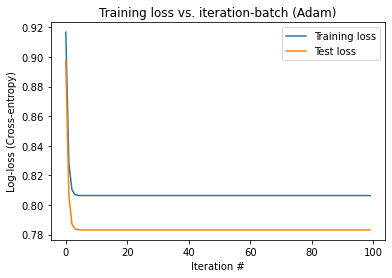

In [17]:
# build logistic regression model
alpha = 10**-3
beta1 = 0.9
beta2 = 0.999
epsilon = 10**-8

losses = torch.Tensor([])
model = nn.Linear(in_features=784, out_features=10, bias=True)
criterion = nn.CrossEntropyLoss()

# run optimization loop

#all_params = torch.cat([param.view(-1) for param in model.parameters() if param.requires_grad])
#print(all_params)
k = 0
m1 = torch.zeros(10, 784)
m2 = torch.zeros(10, 784)
for i in range(num_loops):
    # forward pass
    # calculate gradient
    y_hat = model(mnist_train)
    loss = criterion(y_hat, y_train) + lmda*sum(sum(model.weight.data*model.weight.data))
    model.zero_grad()
    loss.backward()
    
    # set up update
    w = [i for i in model.parameters()][0]
    
    ## set up initial m's
    m1 = beta1 * m1 + (1-beta1)*w.grad
    m2 = beta2 * m2 + (1-beta2)*w.grad*w.grad
    
    ## debias m's
    m1 = m1/(1-beta1**(i+1))
    m2 = m2/(1-beta2**(i+1))
    
    # update weight
    w = w - alpha * m1 / (epsilon + torch.sqrt(m2))
    
    # update losses
    test_loss = criterion(model(mnist_test), y_test)
    losses = torch.cat((losses, torch.Tensor([[1, i, loss, test_loss]])), dim=0)
    
    # move weights back into model
    model.weight.data = w
    
# plot training/test loss
plt.figure()
plt.plot(losses[:,1].numpy(), np.log(losses[:,2].numpy()), marker='')
plt.plot(losses[:,1].numpy(), np.log(losses[:,3].numpy()), marker='')
plt.xlabel("Iteration #")
plt.ylabel("Log-loss (Cross-entropy)")
plt.legend(["Training loss", "Test loss"])
plt.title(f"Training loss vs. iteration-batch (Adam)")
plt.show()